In [76]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# --- 1. Settings ---

In [77]:

script_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/scMulti_merged_matrix"
os.chdir(script_dir)
print(f"Working directory set to: {script_dir}")

Working directory set to: /beegfs/scratch/ric.broccoli/kubacki.michal/scMulti_merged_matrix


In [78]:
# Set verbosity to 3 to see more informative output
sc.settings.verbosity = 3
# Set figure parameters
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- 2. Load Data ---

In [79]:
print("Loading data...")
data_dir = 'filtered_feature_bc_matrix/'
adata = sc.read_10x_mtx(
    data_dir,
    var_names='gene_symbols',
    cache=True)

Loading data...
... reading from cache file cache/filtered_feature_bc_matrix-matrix.h5ad


In [80]:
adata.var_names_make_unique()

In [81]:
print("Data loaded successfully.")
print(adata)

Data loaded successfully.
AnnData object with n_obs × n_vars = 10395 × 32285
    var: 'gene_ids', 'feature_types'


# --- 3. Preprocessing and Quality Control (QC) ---


Starting preprocessing and QC...
normalizing counts per cell
    finished (0:00:00)


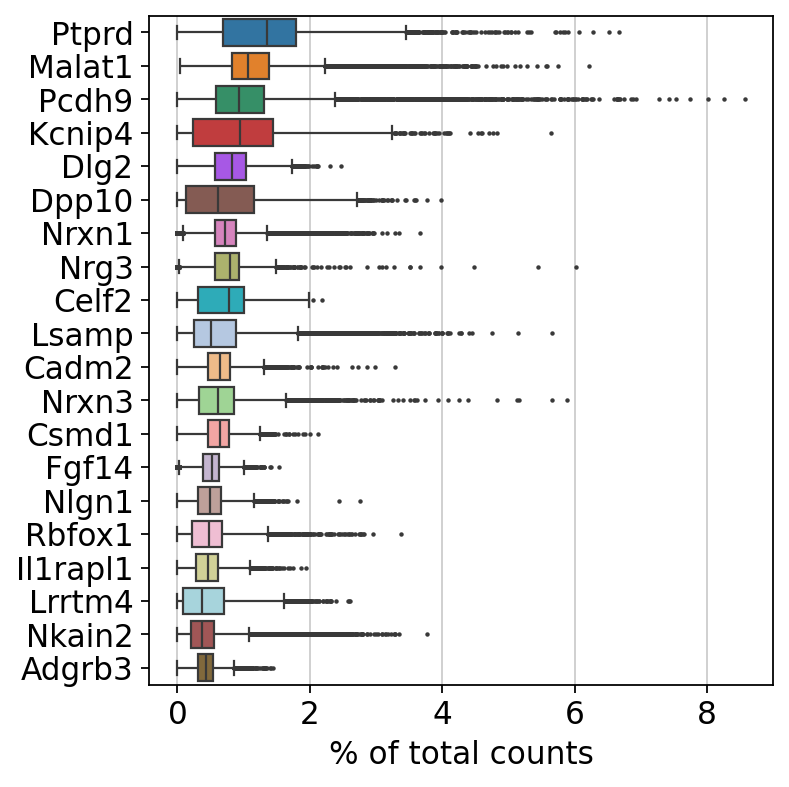

In [83]:
print("\nStarting preprocessing and QC...")

# Show genes that have the highest expression in absolute counts, per cell
sc.pl.highest_expr_genes(adata, n_top=20, save='_highest_expr_genes.png')

In [84]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Store original cell count
n_cells_before = adata.n_obs
print(f"Starting with {n_cells_before} cells")

Starting with 10395 cells


In [85]:
# ========== PERCENTILE-BASED FILTERING ==========

# Calculate percentiles for each QC metric
# Using 2.5th and 97.5th percentiles to remove extreme 5% of cells
n_genes_lower = np.percentile(adata.obs['n_genes_by_counts'], 2.5)
n_genes_upper = np.percentile(adata.obs['n_genes_by_counts'], 97.5)

# Total counts (UMIs)
counts_lower = np.percentile(adata.obs['total_counts'], 2.5)
counts_upper = np.percentile(adata.obs['total_counts'], 97.5)

# Mitochondrial percentage
mt_upper = 20

print("Percentile-based thresholds:")
print(f"  Number of genes: {n_genes_lower:.0f} - {n_genes_upper:.0f}")
print(f"  Total counts: {counts_lower:.0f} - {counts_upper:.0f}")
print(f"  Mitochondrial %: < {mt_upper:.2f}%")

# Count cells that will be filtered by each criterion
n_genes_filter = (adata.obs['n_genes_by_counts'] < n_genes_lower) | (adata.obs['n_genes_by_counts'] > n_genes_upper)
counts_filter = (adata.obs['total_counts'] < counts_lower) | (adata.obs['total_counts'] > counts_upper)
mt_filter = adata.obs['pct_counts_mt'] > mt_upper

print(f"\nCells filtered by each criterion:")
print(f"  n_genes: {n_genes_filter.sum()} cells")
print(f"  total_counts: {counts_filter.sum()} cells")
print(f"  pct_counts_mt: {mt_filter.sum()} cells")

Percentile-based thresholds:
  Number of genes: 1555 - 11259
  Total counts: 2969 - 230975
  Mitochondrial %: < 20.00%

Cells filtered by each criterion:
  n_genes: 517 cells
  total_counts: 520 cells
  pct_counts_mt: 0 cells



After filtering: 9800 cells
Removed 595 cells (5.7%)

Filtering genes expressed in < 3 cells...
filtered out 6371 genes that are detected in less than 3 cells
Removed 6371 genes


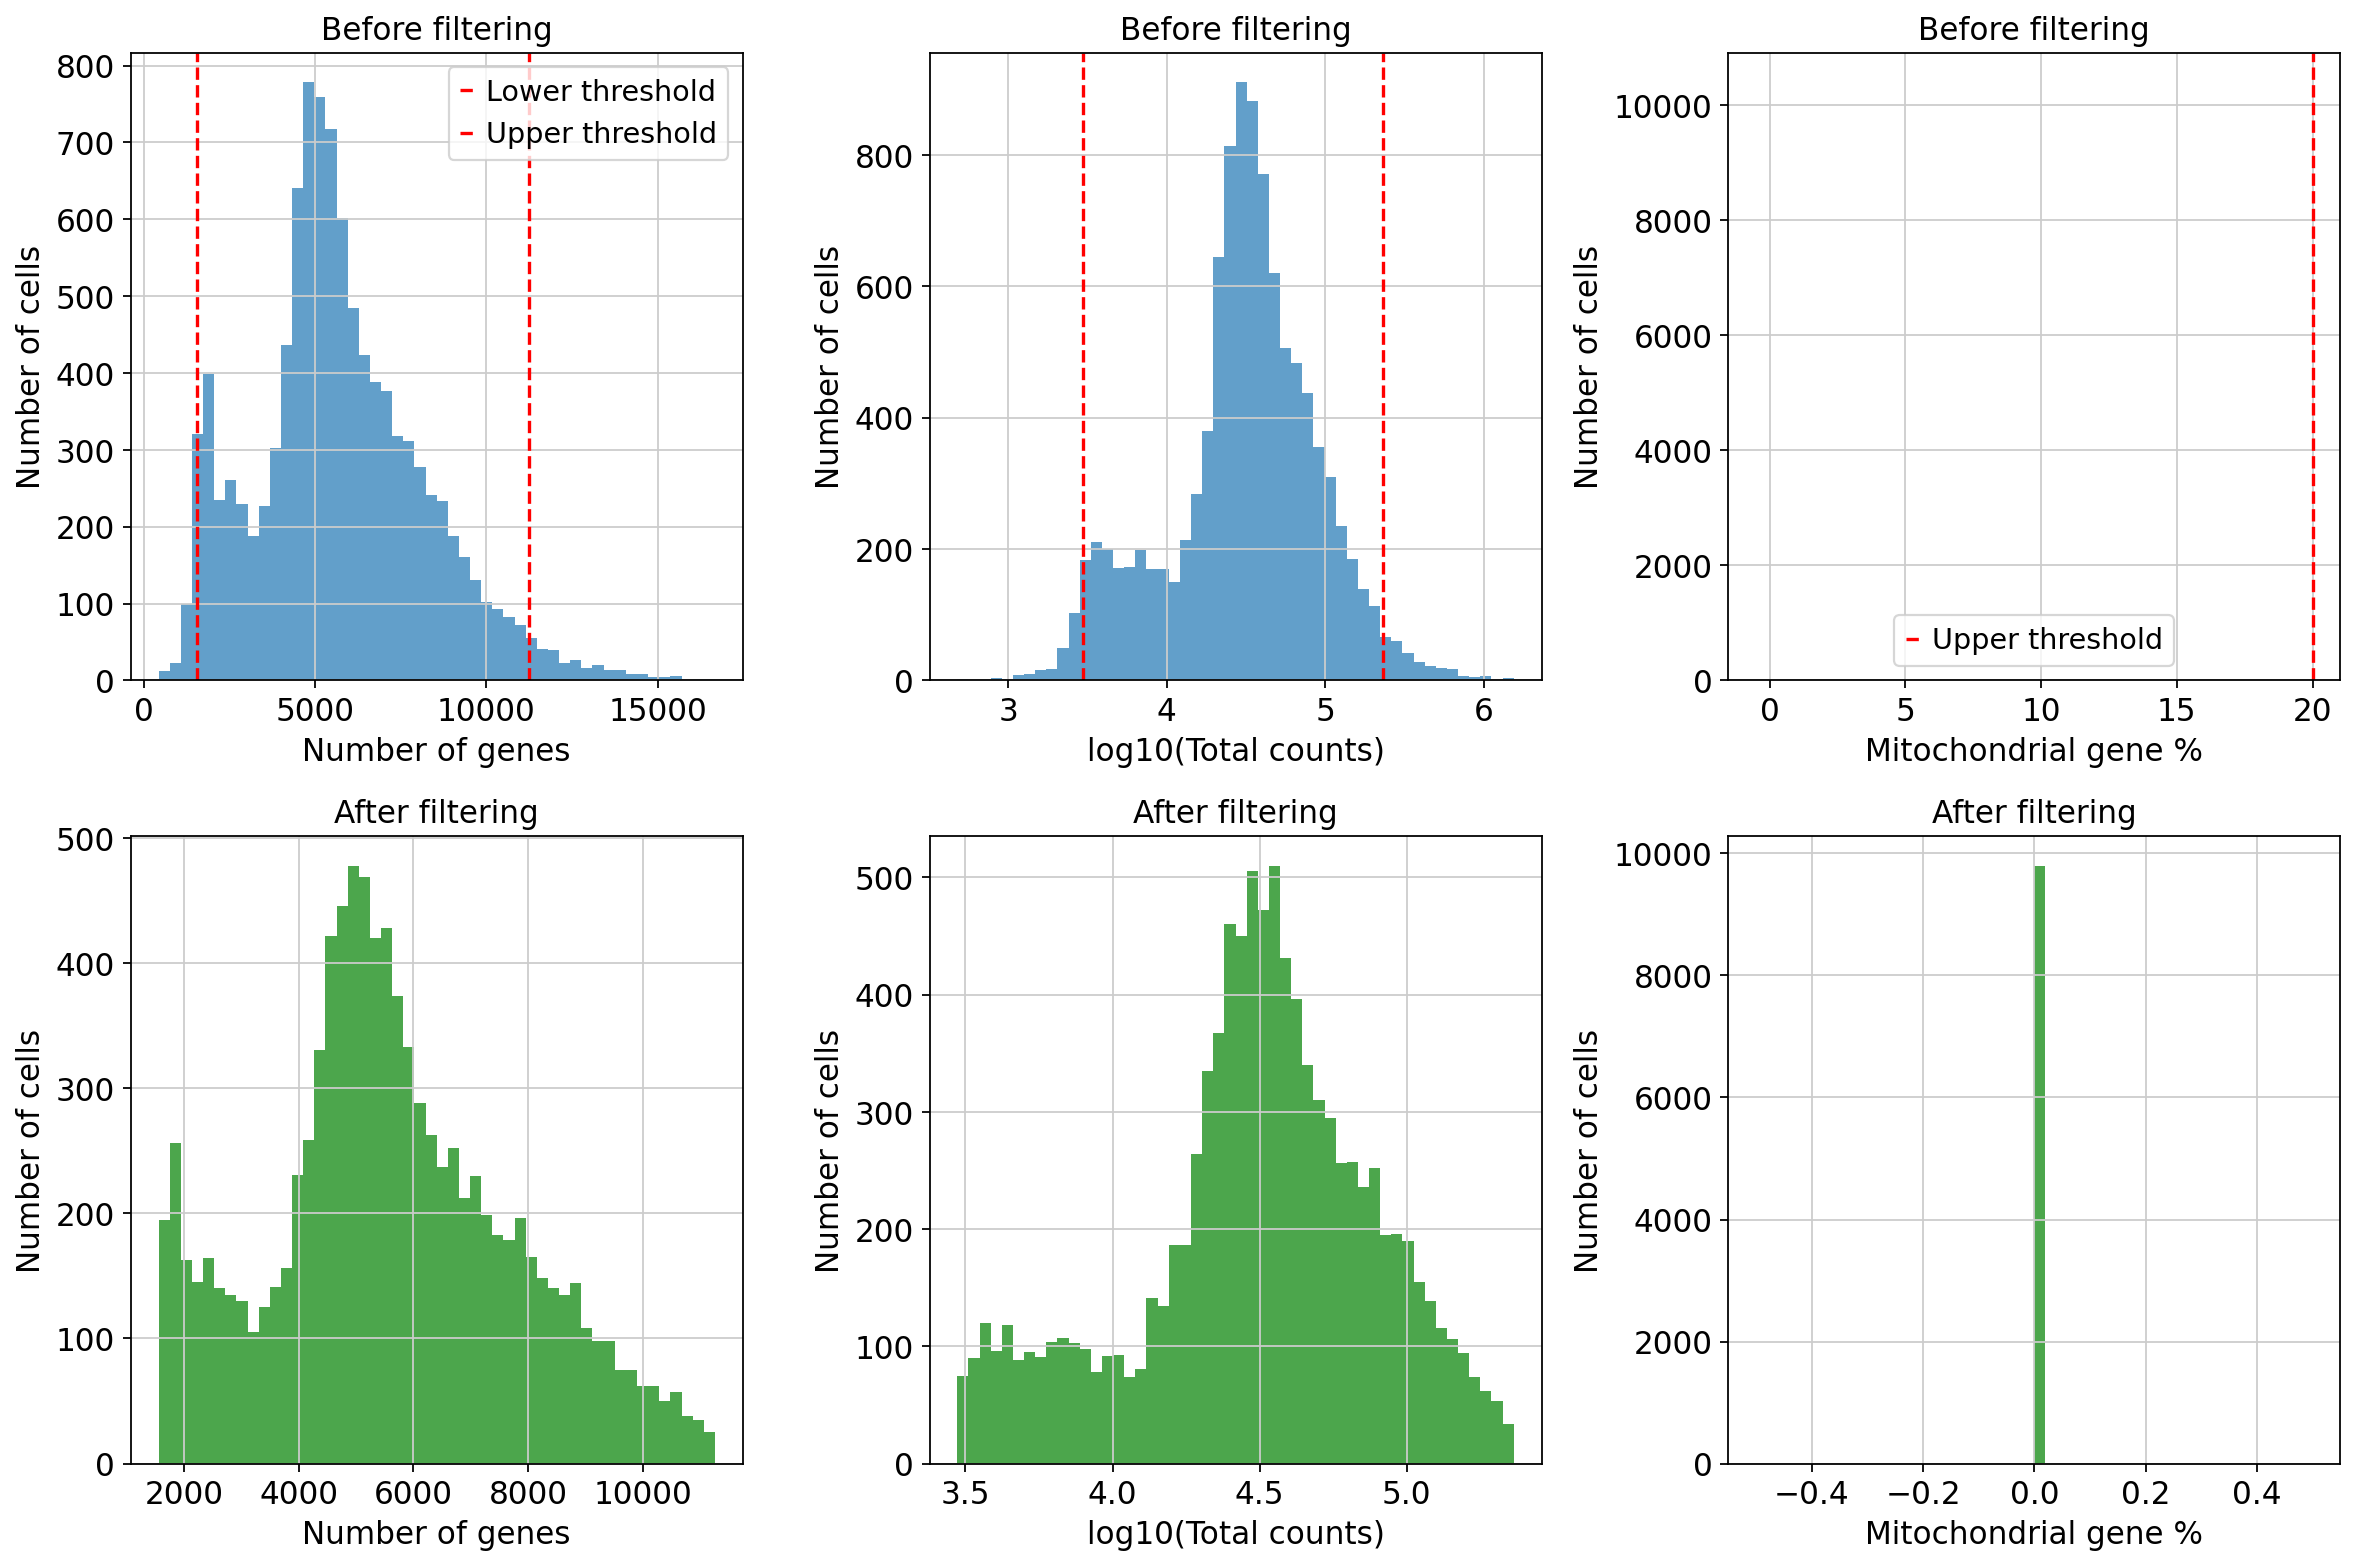

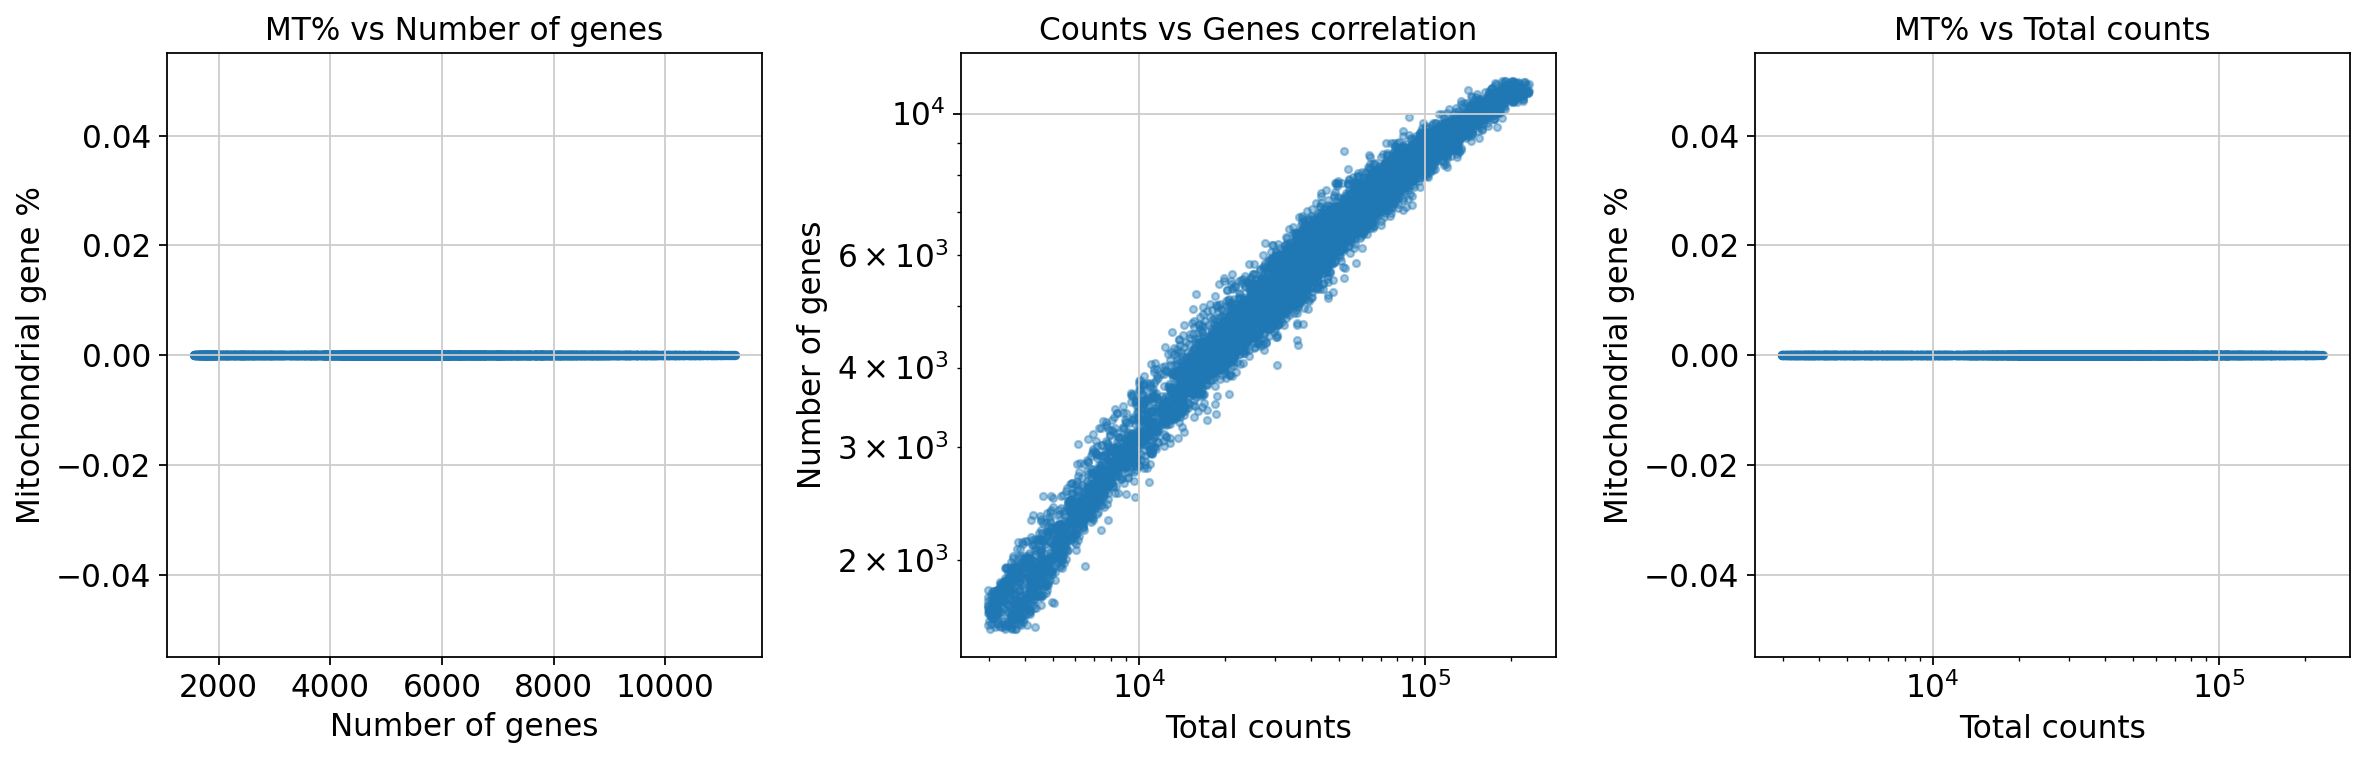

In [86]:
# ========== VISUALIZATION ==========

# Save original QC metrics before filtering for visualization
orig_n_genes = adata.obs['n_genes_by_counts'].copy()
orig_total_counts = adata.obs['total_counts'].copy()
orig_pct_mt = adata.obs['pct_counts_mt'].copy()

# Apply all filters
keep_cells = (
    (adata.obs['n_genes_by_counts'] >= n_genes_lower) & 
    (adata.obs['n_genes_by_counts'] <= n_genes_upper) & 
    (adata.obs['total_counts'] >= counts_lower) & 
    (adata.obs['total_counts'] <= counts_upper) & 
    (adata.obs['pct_counts_mt'] <= mt_upper)
)

# Filter the data
adata = adata[keep_cells, :].copy()

n_cells_after = adata.n_obs
print(f"\nAfter filtering: {n_cells_after} cells")
print(f"Removed {n_cells_before - n_cells_after} cells ({100*(n_cells_before - n_cells_after)/n_cells_before:.1f}%)")

# Filter genes expressed in very few cells
min_cells = 3
print(f"\nFiltering genes expressed in < {min_cells} cells...")
n_genes_before_filter = adata.n_vars
sc.pp.filter_genes(adata, min_cells=min_cells)
n_genes_after_filter = adata.n_vars
print(f"Removed {n_genes_before_filter - n_genes_after_filter} genes")

# Create figure with QC plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Before filtering
axes[0, 0].hist(orig_n_genes, bins=50, alpha=0.7)
axes[0, 0].axvline(n_genes_lower, color='red', linestyle='--', label='Lower threshold')
axes[0, 0].axvline(n_genes_upper, color='red', linestyle='--', label='Upper threshold')
axes[0, 0].set_xlabel('Number of genes')
axes[0, 0].set_ylabel('Number of cells')
axes[0, 0].set_title('Before filtering')
axes[0, 0].legend()

axes[0, 1].hist(np.log10(orig_total_counts), bins=50, alpha=0.7)
axes[0, 1].axvline(np.log10(counts_lower), color='red', linestyle='--')
axes[0, 1].axvline(np.log10(counts_upper), color='red', linestyle='--')
axes[0, 1].set_xlabel('log10(Total counts)')
axes[0, 1].set_ylabel('Number of cells')
axes[0, 1].set_title('Before filtering')

axes[0, 2].hist(orig_pct_mt, bins=50, alpha=0.7)
axes[0, 2].axvline(mt_upper, color='red', linestyle='--', label='Upper threshold')
axes[0, 2].set_xlabel('Mitochondrial gene %')
axes[0, 2].set_ylabel('Number of cells')
axes[0, 2].set_title('Before filtering')
axes[0, 2].legend()

# Row 2: After filtering
axes[1, 0].hist(adata.obs['n_genes_by_counts'], bins=50, alpha=0.7, color='green')
axes[1, 0].set_xlabel('Number of genes')
axes[1, 0].set_ylabel('Number of cells')
axes[1, 0].set_title('After filtering')

axes[1, 1].hist(np.log10(adata.obs['total_counts']), bins=50, alpha=0.7, color='green')
axes[1, 1].set_xlabel('log10(Total counts)')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title('After filtering')

axes[1, 2].hist(adata.obs['pct_counts_mt'], bins=50, alpha=0.7, color='green')
axes[1, 2].set_xlabel('Mitochondrial gene %')
axes[1, 2].set_ylabel('Number of cells')
axes[1, 2].set_title('After filtering')

plt.tight_layout()
plt.savefig('figures/qc_histograms_before_after.png', dpi=300, bbox_inches='tight')
plt.show()

# Create scatter plots to show relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MT% vs n_genes
axes[0].scatter(adata.obs['n_genes_by_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.4, s=10)
axes[0].set_xlabel('Number of genes')
axes[0].set_ylabel('Mitochondrial gene %')
axes[0].set_title('MT% vs Number of genes')

# Total counts vs n_genes (log scale)
axes[1].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'], 
                alpha=0.4, s=10)
axes[1].set_xlabel('Total counts')
axes[1].set_ylabel('Number of genes')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('Counts vs Genes correlation')

# MT% vs total counts
axes[2].scatter(adata.obs['total_counts'], adata.obs['pct_counts_mt'], 
                alpha=0.4, s=10)
axes[2].set_xlabel('Total counts')
axes[2].set_ylabel('Mitochondrial gene %')
axes[2].set_xscale('log')
axes[2].set_title('MT% vs Total counts')

plt.tight_layout()
plt.savefig('figures/qc_scatter_filtered.png', dpi=300, bbox_inches='tight')
plt.show()

In [87]:
# ========== SUMMARY STATISTICS ==========

# Create summary DataFrame
summary_stats = pd.DataFrame({
    'Metric': ['Total cells (initial)', 'Total cells (filtered)', 'Cells removed', 
               'Percent cells removed', 'Total genes (initial)', 'Total genes (filtered)',
               'n_genes threshold (lower)', 'n_genes threshold (upper)',
               'total_counts threshold (lower)', 'total_counts threshold (upper)',
               'MT% threshold'],
    'Value': [n_cells_before, n_cells_after, n_cells_before - n_cells_after,
              f"{100*(n_cells_before - n_cells_after)/n_cells_before:.1f}%",
              n_genes_before_filter, n_genes_after_filter,
              f"{n_genes_lower:.0f}", f"{n_genes_upper:.0f}",
              f"{counts_lower:.0f}", f"{counts_upper:.0f}",
              f"{mt_upper:.2f}%"]
})

print("\n" + "="*50)
print("FILTERING SUMMARY")
print("="*50)
print(summary_stats.to_string(index=False))

# Save the summary to file
summary_stats.to_csv('qc_filtering_summary.csv', index=False)

# Optional: Save the filtered data
# adata.write('filtered_adata.h5ad')
print("\nFiltered data is ready for downstream analysis!")


FILTERING SUMMARY
                        Metric  Value
         Total cells (initial)  10395
        Total cells (filtered)   9800
                 Cells removed    595
         Percent cells removed   5.7%
         Total genes (initial)  32285
        Total genes (filtered)  25914
     n_genes threshold (lower)   1555
     n_genes threshold (upper)  11259
total_counts threshold (lower)   2969
total_counts threshold (upper) 230975
                 MT% threshold 20.00%

Filtered data is ready for downstream analysis!


# --- 4. Normalization and Feature Selection ---


Normalizing data and selecting highly variable genes...
normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


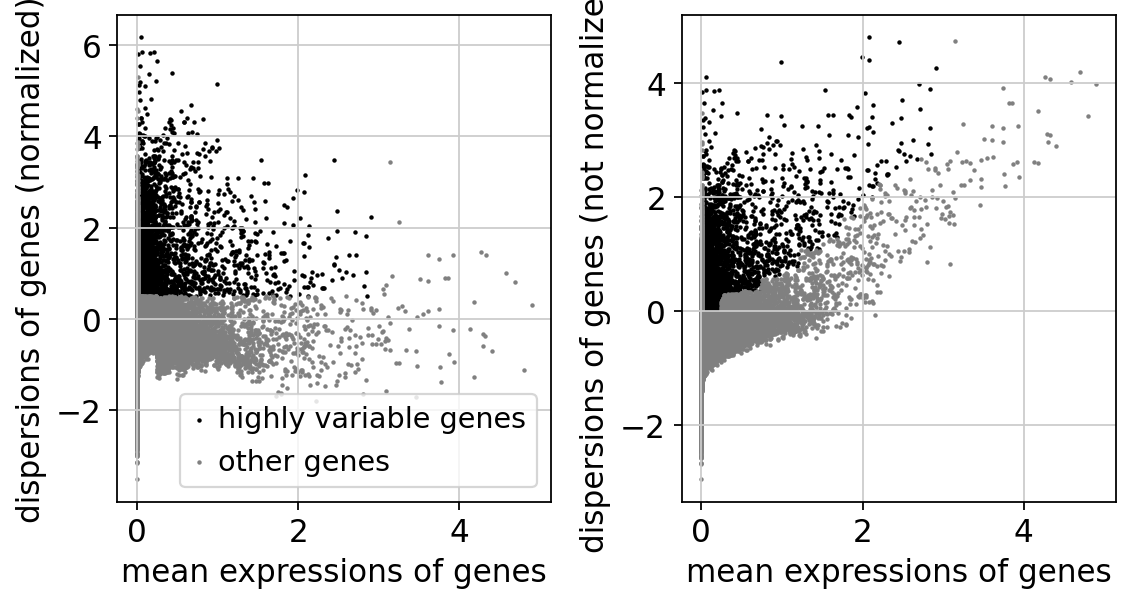

Finished normalization and feature selection.


In [88]:
print("\nNormalizing data and selecting highly variable genes...")

# Normalize each cell by total counts over all genes, so that every cell has the same total count.
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save='_highly_variable_genes.png')

# Slice the AnnData object to keep only highly variable genes
adata = adata[:, adata.var.highly_variable]

print("Finished normalization and feature selection.")

# --- 5. Dimensionality Reduction ---


Performing dimensionality reduction...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/beegfs/scratch/ric.broccoli/kubacki.michal/conda/envs/bioinf/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    with n_comps=50
    finished (0:00:00)


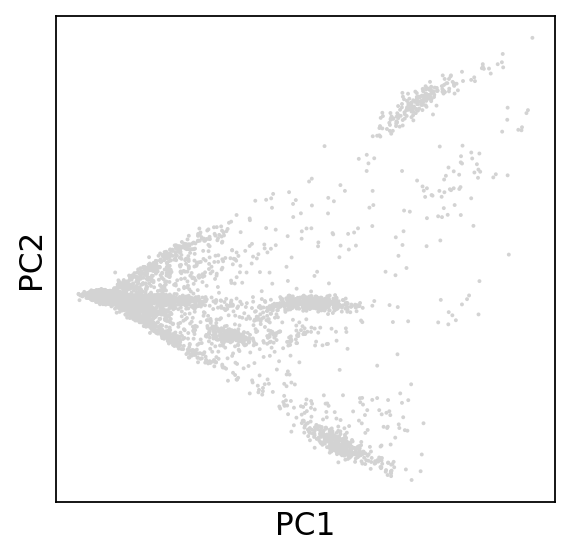

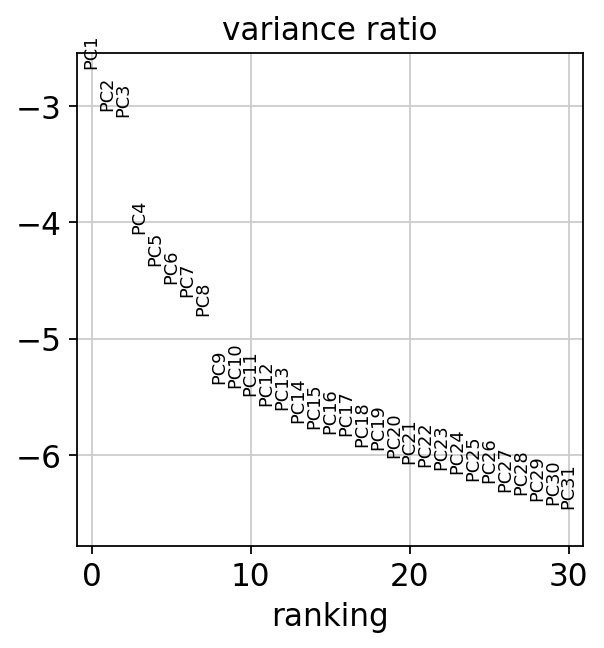

In [89]:
print("\nPerforming dimensionality reduction...")

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

# Principal component analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, save='_pca.png')
sc.pl.pca_variance_ratio(adata, log=True, save='_pca_variance_ratio.png')

# --- 6. Clustering and Visualization ---


Clustering and visualization...
computing neighbors
    using 'X_pca' with n_pcs = 40


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


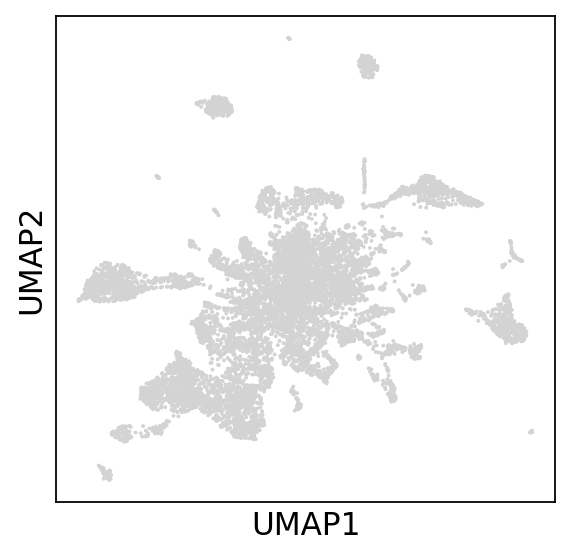

running Leiden clustering
    finished: found 41 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


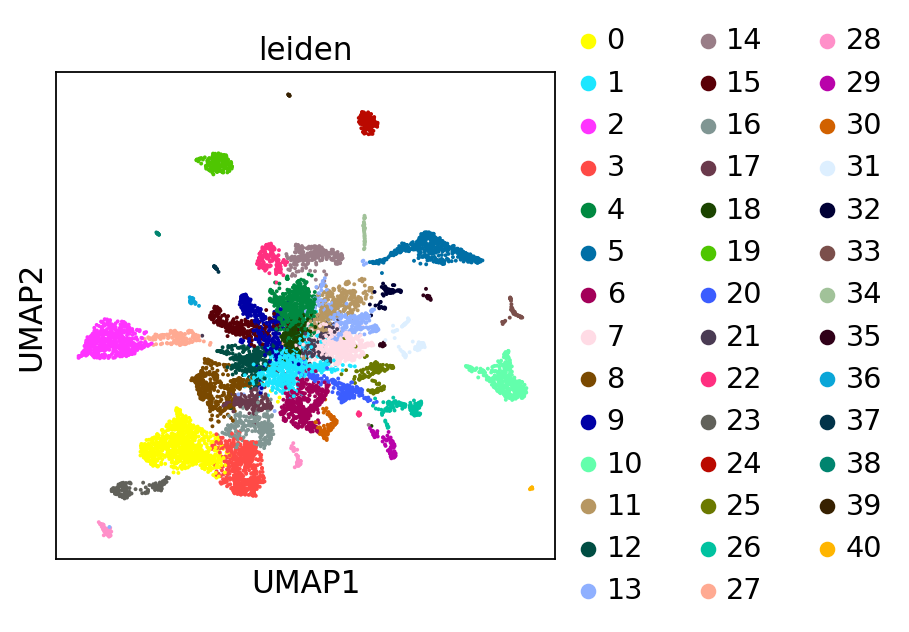


Adding alternative UMAP projection from CSV...


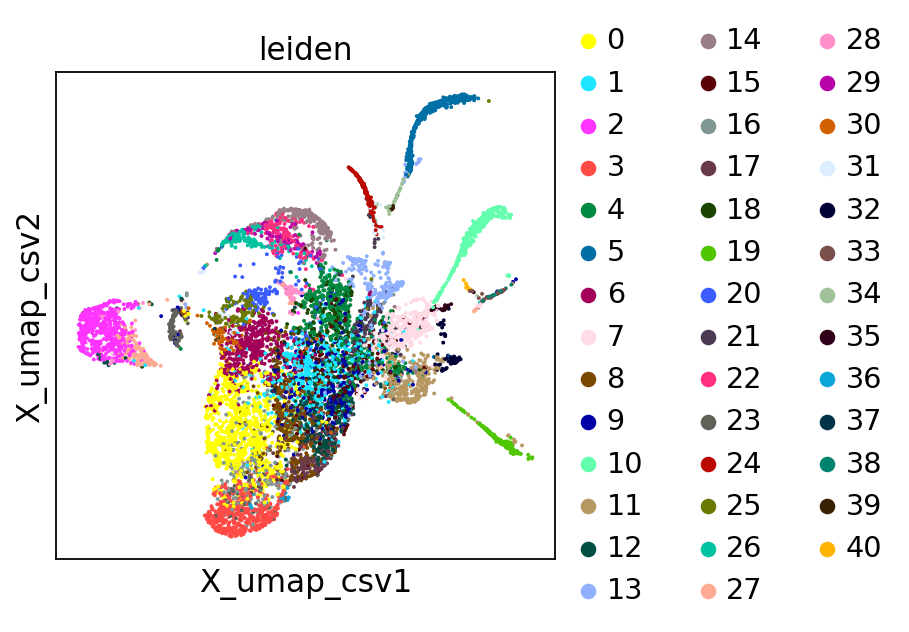


Analysis complete. Results saved to 'figures/' directory.
Final AnnData object:
AnnData object with n_obs × n_vars = 9800 × 3570
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_umap_csv'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Processed data saved to 'processed_data.h5ad'


In [ ]:
print("\nClustering and visualization...")

# Computing the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Embedding the neighborhood graph using UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, save='_umap_markers.png')

# Clustering the neighborhood graph using the Leiden algorithm
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'], save='_umap_leiden.png')

# --- 7. Add alternative UMAP projection ---

In [ ]:
print("\nAdding alternative UMAP projection from CSV...")

# Load the external UMAP projection
umap_df = pd.read_csv('umap_projection.csv', index_col=0)

# Align the dataframes by index (barcodes)
aligned_df = umap_df.reindex(adata.obs_names)

# Add the UMAP coordinates to the AnnData object
adata.obsm['X_umap_csv'] = aligned_df[['UMAP-1', 'UMAP-2']].values

# Plot the new UMAP projection
sc.pl.embedding(adata, basis='X_umap_csv', color=['leiden'], save='_umap_csv_leiden.png')

# --- Save Results ---

In [ ]:
print("\nAnalysis complete. Results saved to 'figures/' directory.")
print("Final AnnData object:")
print(adata)

# Save the final AnnData object
adata.write('processed_data.h5ad')
print("\nProcessed data saved to 'processed_data.h5ad'")